In [1]:
import numpy as np
import pandas as pd
import os
import pyarrow.parquet as pq
import datetime as dt
import networkx as nx

from plotnine import *
from mizani.formatters import percent_format, date_format

import math
from decimal import Decimal, getcontext
getcontext().prec = 50

data_dir = '/Users/zhicong/Dropbox/DEXs'
pool_name = 'USDC-WETH 500 10'

# Functions

In [2]:
def Get_Price(_tick_):
    return Decimal(1/(1.0001**_tick_*10**-12))

# Read and Clean Data

Liquidity provision action

In [3]:
lp_action = pd.read_csv(os.path.join(data_dir, "uniswapv3_lp_actions", pool_name + "_LP.csv"))

# Final cleaning
lp_action['BLOCK_TIMESTAMP'] = pd.to_datetime(lp_action['BLOCK_TIMESTAMP'])
lp_action['AMOUNT0_ADJUSTED'] = np.where(lp_action['EVENT_NAME'] == 'Decrease Liquidity', -lp_action['AMOUNT0_ADJUSTED'], lp_action['AMOUNT0_ADJUSTED'])
lp_action['AMOUNT0_USD'] = np.where(lp_action['EVENT_NAME'] == 'Decrease Liquidity', -lp_action['AMOUNT0_USD'], lp_action['AMOUNT0_USD'])
lp_action['AMOUNT1_ADJUSTED'] = np.where(lp_action['EVENT_NAME'] == 'Decrease Liquidity', -lp_action['AMOUNT1_ADJUSTED'], lp_action['AMOUNT1_ADJUSTED'])
lp_action['AMOUNT1_USD'] = np.where(lp_action['EVENT_NAME'] == 'Decrease Liquidity', -lp_action['AMOUNT1_USD'], lp_action['AMOUNT1_USD'])
lp_action['L'] = np.where(lp_action['EVENT_NAME'] == 'Decrease Liquidity', -lp_action['L'], lp_action['L'])

# Round Liquidity Parameter to 5 decimal point
lp_action['L'] = round(lp_action['L'], 5)

lp_action.head()

,POOL_NAME,EVENT_NAME,BLOCK_NUMBER,BLOCK_TIMESTAMP,SENDER,NF_TOKEN_ID,AMOUNT0_ADJUSTED,TOKEN0_SYMBOL,AMOUNT0_USD,AMOUNT1_ADJUSTED,TOKEN1_SYMBOL,AMOUNT1_USD,TICK_LOWER,TICK_UPPER,PRICE_LOWER,PRICE_UPPER,L
0,USDC-WETH 500 10,Increase Liquidity,12376729,2021-05-05 21:42:11,0xb2ef52180d1e5f4835f4e343251286fa84743456,977,2995.507735,USDC,2995.292327,1.000000,WETH,3437.435736,191150,198080,2499.913599,4998.918171,345.07310
1,USDC-WETH 500 10,Decrease Liquidity,12376958,2021-05-05 22:27:41,0xb2ef52180d1e5f4835f4e343251286fa84743456,977,-2588.187276,USDC,-2588.001158,-0.931484,WETH,-3201.917248,191150,198080,2499.913599,4998.918171,-310.56579
2,USDC-WETH 500 10,Increase Liquidity,12377035,2021-05-05 22:44:11,0x35f5a1ec10deee1256351e37bc78dc80345895f8,1242,1.000000,USDC,0.999928,0.000146,WETH,0.500964,194990,195010,3398.182813,3404.985639,25.65271
3,USDC-WETH 500 10,Increase Liquidity,12377266,2021-05-05 23:34:39,0x9f9b987becfe15aca93ce9208cca146f252c8d46,1428,598.469729,USDC,598.426693,2.600000,WETH,8937.332900,186730,195460,3248.661521,7777.223709,447.99460
4,USDC-WETH 500 10,Increase Liquidity,12377308,2021-05-05 23:44:49,0x9f9b987becfe15aca93ce9208cca146f252c8d46,1464,3405.610348,USDC,3405.365449,0.000000,WETH,0.000000,194660,194990,3404.985639,3519.218937,3508.22475


Swaps action

In [4]:
swaps = pd.DataFrame(columns = ['BLOCK_NUMBER','BLOCK_TIMESTAMP','TX_HASH','SENDER','TX_TO','PLATFORM','POOL_NAME','CONTRACT_ADDRESS',
                                'EVENT_NAME','AMOUNT_IN','SYMBOL_IN','AMOUNT_OUT','SYMBOL_OUT'])

for i in range(1,4):
    temp = pd.read_parquet(os.path.join(data_dir, "dex_swaps", pool_name + "_" + str(i) + ".gzip"))
    swaps = pd.concat([swaps,temp], axis = 0)
    del temp

# Final cleaning
swaps.reset_index(drop = True, inplace = True)
swaps['BLOCK_NUMBER'] = swaps['BLOCK_NUMBER'].astype(int)
swaps['AMOUNT_IN'] = swaps['AMOUNT_IN'].astype(float)
swaps['AMOUNT_OUT'] = swaps['AMOUNT_OUT'].astype(float)
swaps['BLOCK_TIMESTAMP'] = pd.to_datetime(swaps['BLOCK_TIMESTAMP'])

# Since the pool charges a transaction fee of 5 basis point on the incoming token, and stored it elsewhere (not in liquidity pool), we subtract that
#swaps['AMOUNT_IN'] = swaps['AMOUNT_IN']*(1-0.0005)

# Changing signs of addition and extraction
swaps['AMOUNT_OUT'] = -swaps['AMOUNT_OUT']
swaps['AMOUNT0_ADJUSTED'] = np.where(swaps['SYMBOL_IN'] == 'WETH', swaps['AMOUNT_OUT'], swaps['AMOUNT_IN'])
swaps['TOKEN0_SYMBOL'] = 'USDC'
swaps['AMOUNT1_ADJUSTED'] = np.where(swaps['SYMBOL_IN'] == 'WETH', swaps['AMOUNT_IN'], swaps['AMOUNT_OUT'])
swaps['TOKEN1_SYMBOL'] = 'WETH'

swaps = swaps[['POOL_NAME','BLOCK_NUMBER','BLOCK_TIMESTAMP','SENDER','EVENT_NAME','AMOUNT0_ADJUSTED','TOKEN0_SYMBOL','AMOUNT1_ADJUSTED','TOKEN1_SYMBOL']]
swaps.sort_values(by = 'BLOCK_NUMBER', ascending = True, inplace = True)
swaps.reset_index(drop = True, inplace = True)

swaps.head()

,POOL_NAME,BLOCK_NUMBER,BLOCK_TIMESTAMP,SENDER,EVENT_NAME,AMOUNT0_ADJUSTED,TOKEN0_SYMBOL,AMOUNT1_ADJUSTED,TOKEN1_SYMBOL
0,USDC-WETH 500 10,12376891,2021-05-05 22:15:01,0xe592427a0aece92de3edee1f18e0157c05861564,Swap,-119.744094,USDC,0.035000,WETH
1,USDC-WETH 500 10,12377278,2021-05-05 23:37:55,0xe592427a0aece92de3edee1f18e0157c05861564,Swap,499.756414,USDC,-0.144241,WETH
2,USDC-WETH 500 10,12377345,2021-05-05 23:51:36,0xe592427a0aece92de3edee1f18e0157c05861564,Swap,365.000000,USDC,-0.103492,WETH
3,USDC-WETH 500 10,12377364,2021-05-05 23:56:34,0xe592427a0aece92de3edee1f18e0157c05861564,Swap,-176.180828,USDC,0.050000,WETH
4,USDC-WETH 500 10,12377369,2021-05-05 23:57:36,0xe592427a0aece92de3edee1f18e0157c05861564,Swap,-514.279985,USDC,0.146000,WETH


Merging

In [5]:
# Removing new LPs
lp_action = lp_action[lp_action['BLOCK_NUMBER'] <= swaps['BLOCK_NUMBER'].max()]
lp_action.reset_index(drop = True, inplace = True)

data = pd.concat([swaps, lp_action], axis = 0)
data.sort_values(by = 'BLOCK_NUMBER', ascending = True, inplace = True)
data.rename(columns = {'AMOUNT0_ADJUSTED':'Delta USDC', 'AMOUNT1_ADJUSTED':'Delta WETH'}, inplace = True)
data.reset_index(drop = True, inplace = True)
data = data[~((data['Delta WETH'] == 0) & (data['Delta USDC'] == 0))]

data = data[['POOL_NAME','BLOCK_NUMBER','BLOCK_TIMESTAMP','SENDER','EVENT_NAME','Delta WETH','Delta USDC','TICK_LOWER','TICK_UPPER','PRICE_LOWER','PRICE_UPPER','L']]

data.head()

,POOL_NAME,BLOCK_NUMBER,BLOCK_TIMESTAMP,SENDER,EVENT_NAME,Delta WETH,Delta USDC,TICK_LOWER,TICK_UPPER,PRICE_LOWER,PRICE_UPPER,L
0,USDC-WETH 500 10,12376729,2021-05-05 21:42:11,0xb2ef52180d1e5f4835f4e343251286fa84743456,Increase Liquidity,1.000000,2995.507735,191150.0,198080.0,2499.913599,4998.918171,345.07310
1,USDC-WETH 500 10,12376891,2021-05-05 22:15:01,0xe592427a0aece92de3edee1f18e0157c05861564,Swap,0.035000,-119.744094,NaN,NaN,NaN,NaN,NaN
2,USDC-WETH 500 10,12376958,2021-05-05 22:27:41,0xb2ef52180d1e5f4835f4e343251286fa84743456,Decrease Liquidity,-0.931484,-2588.187276,191150.0,198080.0,2499.913599,4998.918171,-310.56579
3,USDC-WETH 500 10,12377035,2021-05-05 22:44:11,0x35f5a1ec10deee1256351e37bc78dc80345895f8,Increase Liquidity,0.000146,1.000000,194990.0,195010.0,3398.182813,3404.985639,25.65271
4,USDC-WETH 500 10,12377266,2021-05-05 23:34:39,0x9f9b987becfe15aca93ce9208cca146f252c8d46,Increase Liquidity,2.600000,598.469729,186730.0,195460.0,3248.661521,7777.223709,447.99460


# Descriptive Statistics

We will be building data descriptives here. One assumption we made here is that each address represents one single agent.

## Basic Descriptive

In [6]:
print("Data period:", data['BLOCK_TIMESTAMP'].min().strftime("%d %B %Y"), "-", data['BLOCK_TIMESTAMP'].max().strftime("%d %B %Y"))
print("Number of actions in our dataset:", len(data))
print("Number of liquidity provision action:", len(data[data['EVENT_NAME'].isin(['Increase Liquidity','Decrease Liquidity'])]))
print("Number of swap action:", len(data[data['EVENT_NAME'].isin(['Swap'])]))

Data period: 05 May 2021 - 12 May 2023
Number of actions in our dataset: 4929727
Number of liquidity provision action: 151554
Number of swap action: 4778173


# Liquidity Providers

## Wallet Issues

There is an issue where Liquidity Providers use one address for liquidity provision and the other for liquidity withdrawal.

We are able to identify these behaviours based on the ids of the NFT token mint, though these tokens are not address specific, if one id's NFT token has been minted and completely burned, i.e. liquidity parameter for that token is 0, we can safely assume that address that has surplus belongs to the same entity to address that has deficit.

In [7]:
cleared_tokens = lp_action[['NF_TOKEN_ID','L']].copy()
cleared_tokens = cleared_tokens.groupby(['NF_TOKEN_ID'])['L'].sum().reset_index()
cleared_tokens = cleared_tokens[np.abs(cleared_tokens['L']) < 0.1]
cleared_tokens = cleared_tokens['NF_TOKEN_ID']
cleared_tokens

0        100014
1        100018
2        100037
3        100055
4        100059
          ...  
67197    ID_995
67198    ID_996
67199    ID_997
67200    ID_998
67201    ID_999
Name: NF_TOKEN_ID, Length: 65238, dtype: object

We can demonstrate this by example.

In [8]:
address_clustering = lp_action[['SENDER','BLOCK_TIMESTAMP','NF_TOKEN_ID','L']].copy()
address_clustering = address_clustering.groupby(['SENDER','NF_TOKEN_ID'])['L'].sum().reset_index()
address_clustering.loc[np.abs(address_clustering['L']) < 0.1,'L'] = 0

# Get example
address_clustering = address_clustering[(address_clustering['L'] != 0) & (address_clustering['NF_TOKEN_ID'].isin(cleared_tokens))].sort_values(by = 'NF_TOKEN_ID')
address_clustering.head(10)

,SENDER,NF_TOKEN_ID,L
12979,0x28a55c4b4f9615fde3cdaddf6cc01fcf2e38a6b0,105901,-9.579148e+05
34722,0x741aa7cfb2c7bf2a1e7d4da2e3df6a56ca4131f3,105901,9.579148e+05
27495,0x581982d0247dc586b00d393e605b17bfb095d637,107364,-8.099860e+00
5405,0x100f82b00e6488ae8c2c6cda5f3162c0fc0107da,107364,8.099860e+00
26402,0x51ac930692175abc3ec450b10ecd41feccb203be,120328,1.596236e+05
51722,0xc0d7f09d052ab72223cf4cad8eafa7c6ba284005,120328,-1.596236e+05
34724,0x741aa7cfb2c7bf2a1e7d4da2e3df6a56ca4131f3,121585,2.458912e+06
12981,0x28a55c4b4f9615fde3cdaddf6cc01fcf2e38a6b0,121585,-2.458912e+06
26404,0x51ac930692175abc3ec450b10ecd41feccb203be,125125,-5.807113e+03
28193,0x5b3e660d669fe4d13d970418205451bd0da79daf,125125,-1.218484e+05


For the addresses above, we will change all address to a single address.

In [9]:
address_clustering = address_clustering.groupby(['NF_TOKEN_ID'])['SENDER'].apply(list).reset_index()
address_clustering = address_clustering['SENDER']

# Concat lists if they share common element
G = nx.Graph()
for l in address_clustering:
    G.add_edges_from(nx.utils.pairwise(l))
connected_components = list(nx.connected_components(G))
address_clustering = pd.DataFrame({'SENDER':[list(comp) for comp in connected_components]})

# Take one address as the shared address for all lists
address_clustering['ADDRESS'] = address_clustering['SENDER'].str[0]
address_clustering = address_clustering.explode('SENDER', ignore_index = True)
address_clustering = address_clustering[['ADDRESS','SENDER']].set_index('SENDER').to_dict()
address_clustering = address_clustering['ADDRESS']

lp_action['SENDER'] = lp_action['SENDER'].replace(address_clustering)

Final check on negative L. For all remaining negative L values, we make a bold assumption that if the token is cleared or if token's price range is too far from current price (>1000 USDC) but there are negative L providers, all addresses that have provided with that token is the same entity. This might not be true if different entities likes to provide within the same range but we are able to make this assumption because we are interested in the current state of the pool and hence cleared tokens are not important in our analysis.

In [10]:
negative_L_check = lp_action[['SENDER','BLOCK_TIMESTAMP','NF_TOKEN_ID','L']].copy()
negative_L_check = negative_L_check.groupby(['SENDER','NF_TOKEN_ID'])['L'].sum().reset_index()
negative_L_check.loc[np.abs(negative_L_check['L']) < 0.1,'L'] = 0
print(negative_L_check[negative_L_check['L'] < 0].sort_values(by = 'NF_TOKEN_ID'))

# Very sure they are the same entity (because there is only one provision with many withdrawal)
lp_action.loc[lp_action['NF_TOKEN_ID'] == '429783','SENDER'] = '0xdef4f7e2f82229776159bb2fb346e6ab5b0a6b08'
lp_action.loc[lp_action['NF_TOKEN_ID'] == 'ID_512','SENDER'] = '0xd40bee376bf7d6939c650bc00dfb76ad7efa7612'
lp_action.loc[lp_action['NF_TOKEN_ID'] == 'ID_2346','SENDER'] = '0xd40bee376bf7d6939c650bc00dfb76ad7efa7612'

# Bold assumption
lp_action.loc[lp_action['NF_TOKEN_ID'] == '187506','SENDER'] = '0xd00fce4966821da1edd1221a02af0afc876365e4'
lp_action.loc[lp_action['NF_TOKEN_ID'] == 'ID_555','SENDER'] = '0x88215a2794ddc031439c72922ec8983bde831c78'
lp_action.loc[lp_action['NF_TOKEN_ID'] == 'ID_1071','SENDER'] = '0x1eee60f0d11e97d54ec55af6a39ed470e2acec0a'
lp_action.loc[lp_action['NF_TOKEN_ID'] == 'ID_2389','SENDER'] = '0xfbe09b7a6c6cc3a72b4ca41cdd9c88ac62bb7937'
lp_action.loc[lp_action['NF_TOKEN_ID'] == 'ID_1499','SENDER'] = '0xfea35be9327aca7beffc93d2b0cfea5d291f7d13'

                                           SENDER NF_TOKEN_ID           L
49090  0xbeb730172e5f8cee9108b8dab3b1fa0069e45ecc      187506  -635.20442
20414  0x455210daaff5378f74d894efb7719749d60e0fe3      187506  -573.05015
17137  0x3a43ace38aeaca3073901b14d97dadf660693e1f      187506   -89.48132
14353  0x33d1edf4e954661c84114fd6f2cd545e7283d7b9      187506   -15.29122
49302  0xc03b7a303ff86ccdefe7a880568545d95925b230      187506  -220.40553
...                                           ...         ...         ...
41166  0x9b0c19000a8631c1f555bb365bde308384e4f2ff      ID_555   -28.84300
44164  0xaa60084b1170bce4b6aaa1c56c1aa5f3dca85923      ID_555   -54.33123
44595  0xac5406aebe35a27691d62bfb80eefcd7c0093164      ID_555 -5010.33698
44375  0xaabb54394e8dd61dd70897e9c80be8de7c64a895      ID_555    -2.53083
31538  0x6745c0d72b69341543f5acd02f27c17074a4d40f      ID_555    -2.41877

[70 rows x 3 columns]


At last, we can check the number of unique liquidity providers in the Uniswap V3 WETH-USDC 500 10 pool.

In [11]:
print("Total Number of unique Liquidity Provider:", len(lp_action['SENDER'].unique()))

Total Number of unique Liquidity Provider: 8978


Note that this method does not clear the issues of wallet addresses. For NFT tokens that are not cleared, i.e. some addresses still holds that NFT, we are unable to match addresses and hence they will still appear as negative L in our dataset. But there are only a total of 1 such addresses which is relatively small compared to a total of 9000 LPs, in further analysis, we will remove these addresses.

## Pool Concentration

Now, we are interested in the concentration of liquidity providers in our liquidity pool, that is the percentage of total "L" in the pool that are provided by top 10 LPs.

In [12]:
lp_pool_concentration = lp_action[['SENDER','BLOCK_TIMESTAMP','L']].copy()
lp_pool_concentration = lp_pool_concentration.groupby(['SENDER'])['L'].sum().reset_index()

# Solve rounding errors
lp_pool_concentration.loc[np.abs(lp_pool_concentration['L']) < 0.1,'L'] = 0
lp_pool_concentration.sort_values(by = ['L'], ascending = False, inplace = True)

# Calculate percentages
lp_pool_concentration['total_L'] = lp_pool_concentration['L'].sum()
lp_pool_concentration['perc_L'] = round(lp_pool_concentration['L']/lp_pool_concentration['total_L'], 2)
lp_pool_concentration = lp_pool_concentration[['SENDER','L','perc_L']]
lp_pool_concentration.head()

,SENDER,L,perc_L
3938,0x7055b17a1b911b6b971172c01ff0cc27881aea94,3.252769e+07,0.23
8872,0xfcf1dd2d209aeb1323dd9a0f2ea65187c84d6c8a,2.550325e+07,0.18
5926,0xaa6a4e4b1c2699ae183637879270b930c5fce885,1.948988e+07,0.14
222,0x0643b30c218a1e087f63bc4ad4285eca0c316b63,9.597280e+06,0.07
1067,0x1eab3b222a5b57474e0c237e7e1c4312c1066855,8.269589e+06,0.06


We can plot this as a cumulative function.

/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/scales/scale.py:102: PlotnineWarning: scale_y_continuous could not recognise parameter `ylim`
/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 5 in image.
/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./Plots/Cumulative distribution of liquidity by top 100 liquidity providers.png
/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 8878 rows containing missing values.
/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 8878 rows containing missing values.


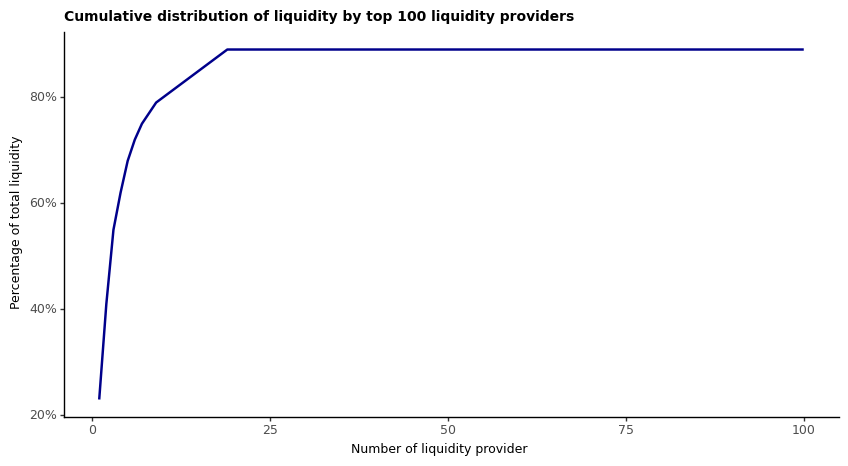

In [13]:
lp_pool_concentration['cum_perc_L'] = lp_pool_concentration['perc_L'].cumsum()
lp_pool_concentration['no_sender'] = np.arange(1,len(lp_pool_concentration)+1,1)

fig = (
ggplot(lp_pool_concentration) + 
    geom_line(aes(x = 'no_sender', y = 'cum_perc_L'), color = 'darkblue', size = 1) + 
    
    scale_y_continuous(labels = percent_format()) +
    xlim(1,100) +
    
    theme_classic() +
    theme(plot_title = element_text(size = 10, face = 'bold', ha = 'left'),
          axis_title_x = element_text(size = 9),
          axis_text_x = element_text(size = 9),
          axis_title_y = element_text(size = 9),
          axis_text_y = element_text(size = 9),
          figure_size = (10,5)) +
    labs(title = 'Cumulative distribution of liquidity by top 100 liquidity providers',
         x = 'Number of liquidity provider', y = 'Percentage of total liquidity')
)

fig.save('./Plots/Cumulative distribution of liquidity by top 100 liquidity providers.png', dpi = 1000)

print(fig)

We are also interested in how concentration changed over time.

In [15]:
concentration_by_time = lp_action[['SENDER','BLOCK_TIMESTAMP','L']].copy()
concentration_by_time = concentration_by_time.groupby(['SENDER','BLOCK_TIMESTAMP'])['L'].sum().reset_index()

# Pivot into a dataframe with rows being timestamp and columns being addresses
concentration_by_time = concentration_by_time.pivot(index = 'BLOCK_TIMESTAMP', columns = 'SENDER', values = 'L')
concentration_by_time.fillna(0, inplace = True)
concentration_by_time = concentration_by_time.apply(np.cumsum)

# Solve rounding errors
concentration_by_time[concentration_by_time < 0.1] = 0
concentration_by_time['total'] = concentration_by_time.sum(axis = 1)

# Get top n LPs and total LP of the pool
n = 10
concentration_by_time = concentration_by_time.apply(np.sort, args = (), axis = 1).apply(lambda x: x[-(n+1):]).apply(pd.Series)
concentration_by_time.columns = ['num_' + str(i) for i in np.arange(n,0,-1)] + ['total']
concentration_by_time['top10_total'] = concentration_by_time.iloc[:,:-1].sum(axis = 1)
concentration_by_time['top10_perc'] = round(concentration_by_time['top10_total']/concentration_by_time['total'],2)
concentration_by_time.reset_index(inplace = True)

concentration_by_time.head()

,BLOCK_TIMESTAMP,num_10,num_9,num_8,num_7,num_6,num_5,num_4,num_3,num_2,num_1,total,top10_total,top10_perc
0,2021-05-05 21:42:11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,345.07310,345.07310,345.07310,1.0
1,2021-05-05 22:27:41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,34.50731,34.50731,34.50731,1.0
2,2021-05-05 22:44:11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,25.65271,34.50731,60.16002,60.16002,1.0
3,2021-05-05 23:34:39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.65271,34.50731,447.99460,508.15462,508.15462,1.0
4,2021-05-05 23:44:49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.65271,34.50731,3956.21935,4016.37937,4016.37937,1.0


We can plot this into a graph.

/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/scales/scale.py:102: PlotnineWarning: scale_y_continuous could not recognise parameter `ylim`
/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 5 in image.
/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./Plots/Percentage of liquidity provided by top 10 liquidity providers.png


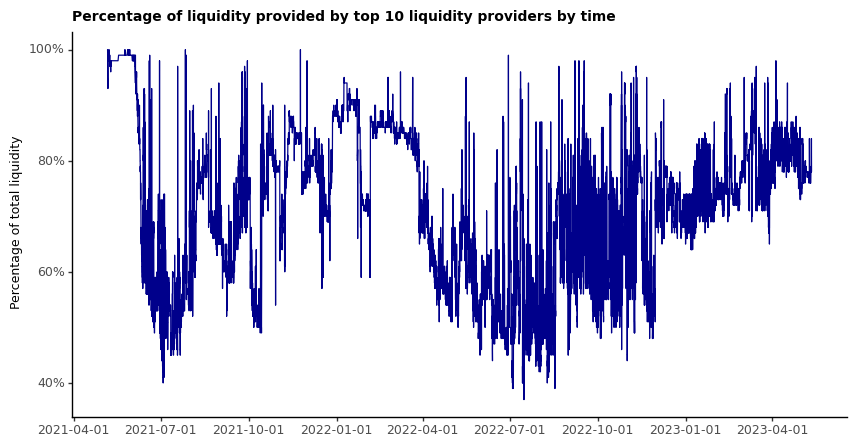

In [16]:
fig = (
ggplot(concentration_by_time) + 
    geom_line(aes(x = 'BLOCK_TIMESTAMP', y = 'top10_perc'), color = 'darkblue', size = 0.5) + 
    
    scale_y_continuous(labels = percent_format()) +
    
    theme_classic() +
    theme(plot_title = element_text(size = 10, face = 'bold', ha = 'left'),
          axis_title_x = element_text(size = 9),
          axis_text_x = element_text(size = 9),
          axis_title_y = element_text(size = 9),
          axis_text_y = element_text(size = 9),
          figure_size = (10,5)) +
    labs(title = 'Percentage of liquidity provided by top 10 liquidity providers by time',
         x = '', y = 'Percentage of total liquidity')
)

fig.save('./Plots/Percentage of liquidity provided by top 10 liquidity providers.png', dpi = 1000)

print(fig)

# Traders

In [ ]:
print("Total Number of unique Traders:", len(swaps['SENDER'].unique()))